In [1]:
#Load packages
from netCDF4 import Dataset
import numpy as np
import matplotlib.colors as colors
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
import sys
import netCDF4 as nc4
sys.path.append("../TRAINING")
from CNN_tools import *
from CNN_UNET import *
from pytorch_lightning.callbacks import ModelCheckpoint
from variables import *
from tools_analyse import *
import importlib
import numpy as np
import os

#Module croco
from Modules import *

def diag_EKE_mean(EKE_mean,list_month_eke):
    
    list_eke_month = []
    for i in range(1,13):
        #print(i)
        index_month = np.argwhere(list_month_eke==i)
        list_EKE_month_i = EKE_mean[index_month].ravel()
        #print(list_EKE_month_i.shape)
        list_eke_month.append(list_EKE_month_i)

    list_eke_month_mean = np.zeros(12)
    for i in range(12):
        list_eke_month_mean[i] = np.median(list_eke_month[i])
        list_eke_month_mean[i] = np.nanmean(list_eke_month[i])

    #plt.plot(list_eke_month_mean)

    return list_eke_month_mean,list_eke_month

# Load data

In [2]:

folder = '/home/datawork-lemar-apero/tpicard/EKE/'
name_nc = 'MKE_EKE_box1040km_windows30j_sample20.nc'
file = folder+name_nc
nc = nc4.Dataset(file,'r')
EKE = np.asfortranarray(nc.variables['EKE'][:,:])
KEbar = np.asfortranarray(nc.variables['MKE'][:,:])
date_EKE = np.asfortranarray(nc.variables['time'][:])
nc.close()


tstart = int(date_EKE[0])
my_simul = 'aperitif_simu2'
str_para = ' [{0},{1},{2},{3},[1,100,1]] '.format(jc-260,jc+260,ic-260,ic+260)
parameters = my_simul +str_para+ format(tstart)
simul = load(simul = parameters, floattype=np.float64, output=False)
f = simul.f
print(simul.year)
print(simul.date)

args (['aperitif_simu2', '[357,877,1308,1828,[1,100,1]]', '1930'],)
args[0] ['aperitif_simu2', '[357,877,1308,1828,[1,100,1]]', '1930']
len(args[0]) 3
2003
Aug 08 - 00:00


# Monthly stats

In [3]:
level_200 = 4
level_400 = 8
level_500 = 10 
level_600 = 12
level_700 = 14 
level = level_200

gap = 60

KE_600_1000_30 = np.nanmean(EKE[:,level_600:,gap:-gap,gap:-gap],axis=(1,2,3))
KE_200_400_30 = np.nanmean(EKE[:,level_200:level_400,gap:-gap,gap:-gap],axis=(1,2,3))
KE_200_1000_30 = np.nanmean(EKE[:,level_200:,gap:-gap,gap:-gap],axis=(1,2,3))


KEbar_600_1000_30 = np.nanmean(KEbar[:,level_600:,gap:-gap,gap:-gap],axis=(1,2,3))
KEbar_200_400_30 = np.nanmean(KEbar[:,level_200:level_400,gap:-gap,gap:-gap],axis=(1,2,3))
KEbar_200_600_30 = np.nanmean(KEbar[:,level_200:,gap:-gap,gap:-gap],axis=(1,2,3))

print(EKE.shape)
nb_dt = int(EKE.shape[0])

from datetime import timedelta
from datetime import date

#### TO EDIT ! ####
d0 = date(2003, 8, 13) 
#### TO EDIT ! ####

d0_mean = d0 + timedelta(days=0) # 1940 ?

list_date = []

for i in range(nb_dt):
    list_date.append(str(d0_mean+timedelta(days=10*i)))

list_date_np = np.asarray(list_date)

list_month_eke = np.zeros(list_date_np.shape[0])

for i in range(list_date_np.shape[0]):
    list_month_eke[i] = int(list_date_np[i][5:7])

ke_month_600_30,ke_month_mean_depth = diag_EKE_mean(KE_600_1000_30,list_month_eke)
ke_month_200_30,ke_month_mean_depth = diag_EKE_mean(KE_200_1000_30,list_month_eke)
ke_month_200_400_30,ke_month_mean_depth = diag_EKE_mean(KE_200_400_30,list_month_eke)

kebar_month_600_30,ke_month_mean_depth = diag_EKE_mean(KEbar_600_1000_30,list_month_eke)
kebar_month_200_30,ke_month_mean_depth = diag_EKE_mean(KEbar_200_600_30,list_month_eke)
kebar_month_200_400_30,ke_month_mean_depth = diag_EKE_mean(KEbar_200_400_30,list_month_eke)


(197, 21, 520, 520)


In [6]:
import numpy as np
import os

list_month_srt = ['jan','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec']
    
sys.path.append("/home2/datahome/tpicard/python/Python_Modules_p3_pyticles/")
from Modules import *
from Modules_gula import *

#(image_test,pdf_test,pdf_filter_test) = load_data_test_surface_all()
#LOAD super model

folder = "/home2/datahome/tpicard/PhD_MOMOPAR/TRAIN_AND_VALIDATION_CNN/OLD/"

nc = nc4.Dataset(folder+'Super_model_all_surface.nc','r')
super_model_surf = np.asfortranarray(nc.variables['super_model_norm'])
nc.close()


pdf_filter_test = load_pdf_filter_simu2()
pdf_filter_test = np.transpose(pdf_filter_test,(0,2,1,3,4))
pdf_filter_test = pdf_filter_test.reshape(pdf_filter_test.shape[0]*pdf_filter_test.shape[1],8,100,100)
pdf_filter_test = pdf_filter_test[:-36]

list_bhatta_surf = np.zeros(pdf_filter_test.shape[0])
for i in range(pdf_filter_test.shape[0]):
    list_bhatta_surf[i] = 1 - np.sum(np.sqrt(np.abs((np.multiply(super_model_surf[i,:,:], pdf_filter_test[i,-1,:,:])))))
    
#(image_test,pdf_test,pdf_filter_test) = load_data_test_surface_all()
#LOAD super model
nc = nc4.Dataset(folder+'Super_model_all_4L.nc','r')
super_model_4L = np.asfortranarray(nc.variables['super_model_norm'])
nc.close()

list_bhatta_4L = np.zeros(pdf_filter_test.shape[0])
for i in range(pdf_filter_test.shape[0]):
    list_bhatta_4L[i] = 1 - np.sum(np.sqrt(np.abs((np.multiply(super_model_4L[i,:,:], pdf_filter_test[i,-1,:,:])))))
    
list_bhatta_reshape = np.reshape(list_bhatta_surf,(190,36))
from datetime import timedelta
from datetime import date

d0 = date(2003, 7, 24) + timedelta(days=10)
day_10 =timedelta(days=10)
list_date = [str(d0)]
list_ticks=[str(d0)]
list_ticks_loc=[]
for i in range(list_bhatta_reshape.shape[0]-1):
    list_date.append(str(d0+timedelta(days=10*i)))
    
    if i%10 ==0:
        list_ticks_loc.append(i+1)
        list_ticks.append(str(d0+timedelta(days=10*i)))
    
list_date_np = np.asarray(list_date)
list_ticks_np = np.asarray(list_ticks)

list_month = np.zeros(190)
for i in range(190):
    list_month[i] = int(list_date_np[i][5:7])

list_bhatta_month = []

for i in range(1,13):
    #print(i)
    index_month = np.argwhere(list_month==i)
    list_bhatta_month_i = list_bhatta_reshape[index_month,:].ravel()
    #print(list_bhatta_month_i.shape)
    list_bhatta_month.append(list_bhatta_month_i)
    
# Séparation of cases valid and non-valid cases
list_bhatta_v2nv_month = np.zeros(12)
list_bhatta_reshape_surf = np.reshape(list_bhatta_surf,(190,36))
list_bhatta_reshape_4L = np.reshape(list_bhatta_4L,(190,36))
index_non_valid_surf = np.where(list_bhatta_reshape_surf > 0.2,1,0)
index_non_valid_4L = np.where(list_bhatta_reshape_4L > 0.2,1,0)

list_bhatta_nv_month_4L = np.zeros(12)
list_bhatta_nv_month_surf = np.zeros(12)

for i in range(1,13):
    #print(i)
    index_month = np.argwhere(list_month==i)
    list_bhatta_month_i = np.sum(index_non_valid_4L[index_month,:])/ index_non_valid_4L[index_month,:].ravel().shape[0]
    list_bhatta_nv_month_4L[i-1] = list_bhatta_month_i
    
    list_bhatta_month_i = np.sum(index_non_valid_surf[index_month,:])/ index_non_valid_surf[index_month,:].ravel().shape[0]
    list_bhatta_nv_month_surf[i-1] = list_bhatta_month_i


Loading filtered pdf simu2 ...
Pdf filtered simu2 loaded


# Plot

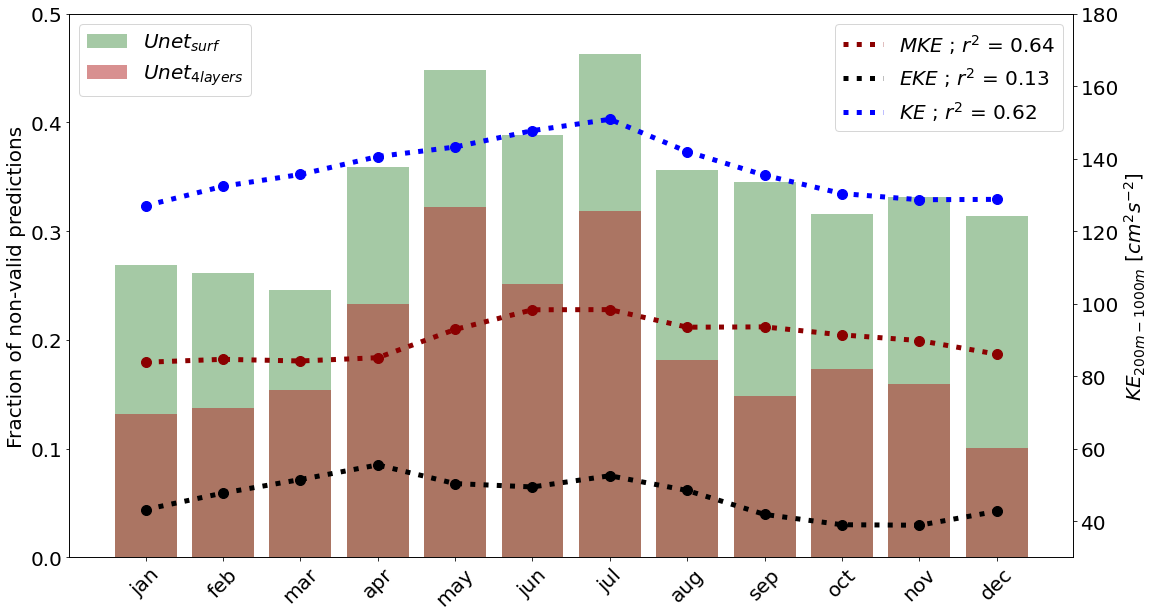

In [7]:
fig, ax1 = plt.subplots(figsize=(18,10))

#plt.ylim(0,1)
plt.xticks(size=20)
plt.yticks(size=20)
plt.ylabel('Fraction of non-valid predictions',size=20)
#plt.xlabel('Month',size=20)
plt.bar(list_month_srt,list_bhatta_nv_month_surf,alpha=0.8,color ='darkseagreen',label = '$Unet_{surf}$')
plt.bar(list_month_srt,list_bhatta_nv_month_4L,alpha=0.5, color='firebrick',label = '$Unet_{4layers}$')
plt.xticks(np.arange(1,13),list_month_srt,size=20,rotation=45)
plt.legend(prop={'size': 20},loc=2)
plt.ylim(0,0.5)
# Ajouter un deuxième axe y pour les données y2
ax2 = ax1.twinx()

color = 'k'
ax2.tick_params(axis='y', labelcolor=color,labelsize=20)
ax2.set_ylabel('$ KE_{200m - 1000m} $ [$cm^2 s^{-2}$]', color=color,size=20)
ax2.set_ylim(30,180)

coefficients,residuals,rank,singular_values,rcond = np.polyfit(list_bhatta_nv_month_surf,kebar_month_200_30, 1, rcond=None, full=True, w=None, cov=False)
regress_coef = 1 - residuals/(np.sum((kebar_month_200_30 - np.mean(kebar_month_200_30))**2))

color = 'darkred'
ax2.plot(list_month_srt, (kebar_month_200_30)*10000, color=color,label='$MKE $'+' ; $r^2$ = {0:.2f}'.format(regress_coef[0]),linestyle=':',linewidth=5)
ax2.scatter(list_month_srt, (kebar_month_200_30)*10000, color=color,s=100)

coefficients,residuals,rank,singular_values,rcond = np.polyfit(list_bhatta_nv_month_surf,ke_month_200_30, 1, rcond=None, full=True, w=None, cov=False)
regress_coef = 1 - residuals/(np.sum((ke_month_200_30 - np.mean(ke_month_200_30))**2))

color = 'k'
ax2.plot(list_month_srt, (ke_month_200_30)*10000, color=color,label='$EKE $'+' ; $r^2$ = {0:.2f}'.format(regress_coef[0]),linestyle=':',linewidth=5)
ax2.scatter(list_month_srt, (ke_month_200_30)*10000, color=color,s=100)

plt.legend(prop={'size': 20},loc=1)

tke_month = ke_month_200_30+kebar_month_200_30
coefficients,residuals,rank,singular_values,rcond = np.polyfit(list_bhatta_nv_month_surf,tke_month, 1, rcond=None, full=True, w=None, cov=False)
regress_coef = 1 - residuals/(np.sum((tke_month - np.mean(tke_month))**2))

color = 'blue'
ax2.plot(list_month_srt, (tke_month)*10000, color=color,label='$KE $'+' ; $r^2$ = {0:.2f}'.format(regress_coef[0]),linestyle=':',linewidth=5)
ax2.scatter(list_month_srt, (tke_month)*10000, color=color,s=100)

plt.legend(prop={'size': 20},loc=1)
#plt.savefig('month_stat_nv_prob.png',dpi = 400)

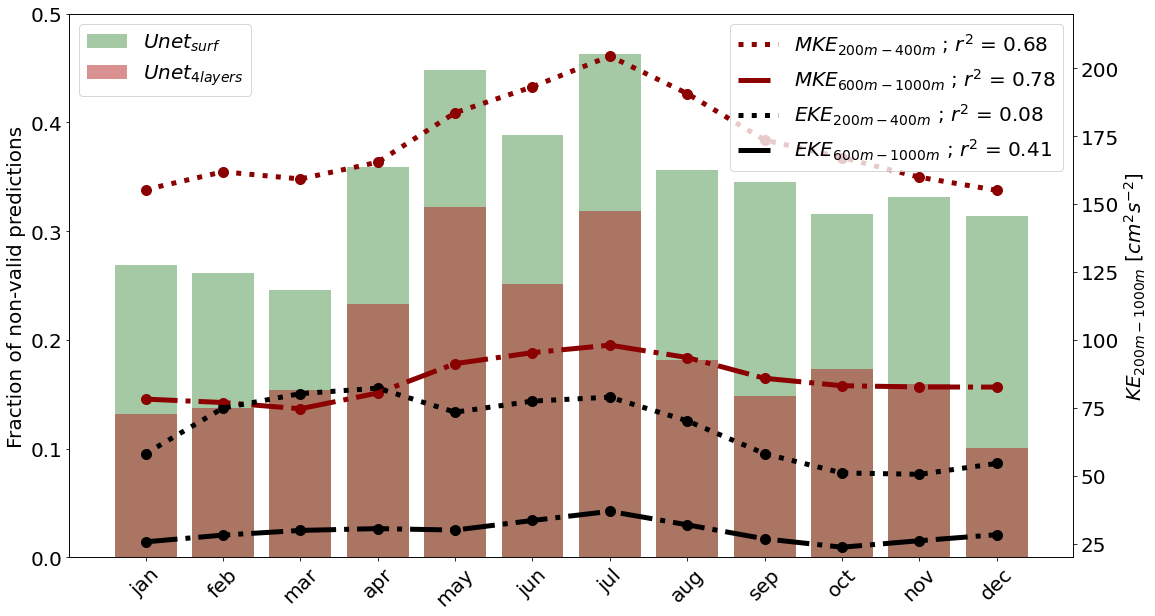

In [89]:
#V2

fig, ax1 = plt.subplots(figsize=(18,10))

#plt.ylim(0,1)
plt.xticks(size=20)
plt.yticks(size=20)
plt.ylabel('Fraction of non-valid predictions',size=20)
#plt.xlabel('Month',size=20)
plt.bar(list_month_srt,list_bhatta_nv_month_surf,alpha=0.8,color ='darkseagreen',label = '$Unet_{surf}$')
plt.bar(list_month_srt,list_bhatta_nv_month_4L,alpha=0.5, color='firebrick',label = '$Unet_{4layers}$')
plt.xticks(np.arange(1,13),list_month_srt,size=20,rotation=45)
plt.legend(prop={'size': 20},loc=2)
plt.ylim(0,0.5)
# Ajouter un deuxième axe y pour les données y2
ax2 = ax1.twinx()

color = 'k'
ax2.tick_params(axis='y', labelcolor=color,labelsize=20)
ax2.set_ylabel('$ KE_{200m - 1000m} $ [$cm^2 s^{-2}$]', color=color,size=20)
ax2.set_ylim(20,220)


coefficients,residuals,rank,singular_values,rcond = np.polyfit(list_bhatta_nv_month_surf,kebar_month_200_400_30, 1, rcond=None, full=True, w=None, cov=False)
regress_coef = 1 - residuals/(np.sum((kebar_month_200_400_30 - np.mean(kebar_month_200_400_30))**2))

color = 'darkred'
ax2.plot(list_month_srt, (kebar_month_200_400_30)*10000, color=color,label='$MKE_{200m-400m} $'+' ; $r^2$ = {0:.2f}'.format(regress_coef[0]),linestyle=':',linewidth=5)
ax2.scatter(list_month_srt, (kebar_month_200_400_30)*10000, color=color,s=100)

coefficients,residuals,rank,singular_values,rcond = np.polyfit(list_bhatta_nv_month_surf,kebar_month_600_30, 1, rcond=None, full=True, w=None, cov=False)
regress_coef = 1 - residuals/(np.sum((kebar_month_600_30 - np.mean(kebar_month_600_30))**2))

color = 'darkred'
ax2.plot(list_month_srt, (kebar_month_600_30)*10000, color=color,label='$MKE_{600m-1000m} $'+' ; $r^2$ = {0:.2f}'.format(regress_coef[0]),linestyle='-.',linewidth=5)
ax2.scatter(list_month_srt, (kebar_month_600_30)*10000, color=color,s=100)


coefficients,residuals,rank,singular_values,rcond = np.polyfit(list_bhatta_nv_month_surf,ke_month_200_400_30, 1, rcond=None, full=True, w=None, cov=False)
regress_coef = 1 - residuals/(np.sum((ke_month_200_400_30 - np.mean(ke_month_200_400_30))**2))

color = 'k'
ax2.plot(list_month_srt, (ke_month_200_400_30)*10000, color=color,label='$EKE_{200m-400m} $'+' ; $r^2$ = {0:.2f}'.format(regress_coef[0]),linestyle=':',linewidth=5)
ax2.scatter(list_month_srt, (ke_month_200_400_30)*10000, color=color,s=100)

coefficients,residuals,rank,singular_values,rcond = np.polyfit(list_bhatta_nv_month_surf,ke_month_600_30, 1, rcond=None, full=True, w=None, cov=False)
regress_coef = 1 - residuals/(np.sum((ke_month_600_30 - np.mean(ke_month_600_30))**2))


color = 'k'
ax2.plot(list_month_srt, (ke_month_600_30)*10000, color=color,label='$EKE_{600m-1000m} $'+' ; $r^2$ = {0:.2f}'.format(regress_coef[0]),linestyle='-.',linewidth=5)
ax2.scatter(list_month_srt, (ke_month_600_30)*10000, color=color,s=100)


plt.legend(prop={'size': 20},loc=1)